In [6]:
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [2]:
data = np.load("data.npy")

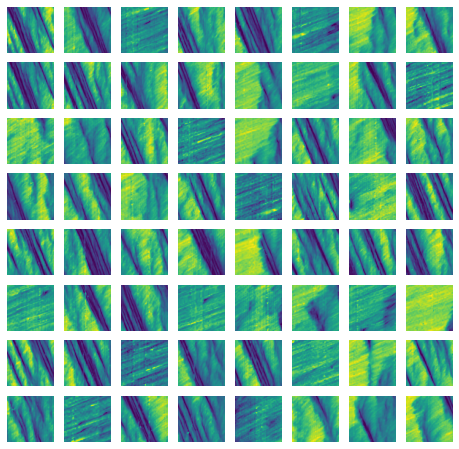

In [3]:
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(data[np.random.randint(data.shape[0])][0].T, origin="lower" )
        ax[i, j].axis("off")

In [4]:
# Normalize the data with min-max scaling

data_min = 0 # data.min()
data_max = data.max()

data = (data - data_min) / (data_max - data_min)

In [5]:
# Split the data into training and validation sets
train_size = int(0.8 * len(data))
val_size = len(data) - train_size

train_data, val_data = torch.utils.data.random_split(data, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

In [7]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen_fc = nn.Sequential(
            nn.Linear(z_dim, 128 * 8 * 8),
            nn.ReLU(True)
        )
        self.gen_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 4, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.gen_fc(x)
        x = x.view(x.size(0), 128, 8, 8)
        x = self.gen_conv(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.disc_conv = nn.Sequential(
            nn.Conv2d(4, 32, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.disc_fc = nn.Sequential(
            nn.Linear(128 * 8 * 8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.disc_conv(x)
        x = x.view(x.size(0), -1)
        x = self.disc_fc(x)
        return x

In [8]:
# Hyperparameters
z_dim = 64  # Size of the noise vector
lr = 0.0002
beta1 = 0.5

# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(z_dim).to(device)
discriminator = Discriminator().to(device)

# Optimizers
optim_gen = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss function
criterion = nn.BCELoss()

In [11]:
# Training loop
num_epochs = 50
real_label = 1.0
fake_label = 0.0

for epoch in range(num_epochs):
    running_loss_D = 0.0
    running_loss_G = 0.0
    for i, data in enumerate(train_loader, 0):
        # Update Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        ## Train with all-real batch
        discriminator.zero_grad()
        real_cpu = data.to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device).float()  # Convert to float
        
        output = discriminator(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        noise = torch.randn(batch_size, z_dim, device=device)
        fake = generator(noise)
        label.fill_(fake_label)
        output = discriminator(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optim_disc.step()
        
        running_loss_D += errD.item()

        # Update Generator: maximize log(D(G(z)))
        generator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = discriminator(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optim_gen.step()
        
        running_loss_G += errG.item()

    # Print averaged loss per epoch
    avg_loss_D = running_loss_D / len(train_loader)
    avg_loss_G = running_loss_G / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}] Loss_D: {avg_loss_D:.4f} Loss_G: {avg_loss_G:.4f}')

# Save the model after training
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')
print("Generator and Discriminator models saved.")

Epoch [1/50] Loss_D: 0.0781 Loss_G: 5.2715
Epoch [2/50] Loss_D: 0.2451 Loss_G: 5.6101
Epoch [3/50] Loss_D: 0.5799 Loss_G: 2.9332
Epoch [4/50] Loss_D: 0.5698 Loss_G: 2.3783
Epoch [5/50] Loss_D: 0.3614 Loss_G: 3.0303
Epoch [6/50] Loss_D: 0.3181 Loss_G: 2.6386
Epoch [7/50] Loss_D: 0.3697 Loss_G: 2.7722
Epoch [8/50] Loss_D: 0.5273 Loss_G: 2.6807
Epoch [9/50] Loss_D: 0.6178 Loss_G: 2.2531
Epoch [10/50] Loss_D: 0.6894 Loss_G: 2.1626
Epoch [11/50] Loss_D: 0.7033 Loss_G: 2.1115
Epoch [12/50] Loss_D: 0.7635 Loss_G: 2.1492
Epoch [13/50] Loss_D: 0.6732 Loss_G: 2.2692
Epoch [14/50] Loss_D: 0.5979 Loss_G: 2.1993
Epoch [15/50] Loss_D: 0.7112 Loss_G: 2.1156
Epoch [16/50] Loss_D: 0.5997 Loss_G: 2.2611
Epoch [17/50] Loss_D: 0.6923 Loss_G: 2.3748
Epoch [18/50] Loss_D: 0.5750 Loss_G: 2.1508
Epoch [19/50] Loss_D: 0.6022 Loss_G: 2.3062
Epoch [20/50] Loss_D: 0.5403 Loss_G: 2.3758
Epoch [21/50] Loss_D: 0.6080 Loss_G: 2.4521
Epoch [22/50] Loss_D: 0.5880 Loss_G: 2.4280
Epoch [23/50] Loss_D: 0.4463 Loss_G: 2.33

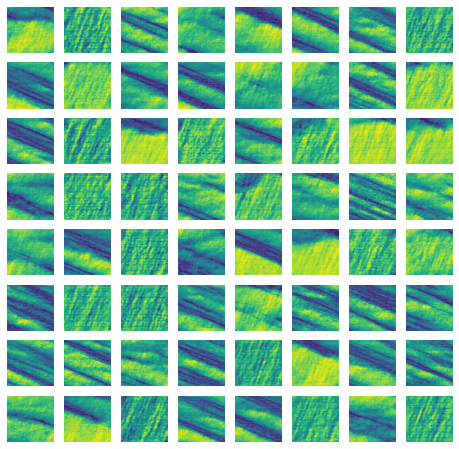

In [11]:
z_dim = 64

device = "cpu"

model = Generator(z_dim).to(device)
model.load_state_dict(torch.load('generator.pth', map_location="cpu"))
model.eval()

# Sample from the latent space
with torch.no_grad():
    z = torch.randn(64, z_dim).to(device)
    sample = model(z).cpu()

# Convert and visualize the sample
sample = sample.permute(0, 2, 3, 1).numpy()

fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(sample[i * 8 + j][:,:,0], origin="lower")
        ax[i, j].axis("off")
plt.show()